<a href="https://colab.research.google.com/github/lukaszplust/Projects/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sklearn.datasets import load_sample_images
import tensorflow as tf

In [ ]:
images = load_sample_images()["images"]
images = tf.keras.layers.CenterCrop(height=70, width=120)(images)
images = tf.keras.layers.Rescaling(scale=1 / 255)(images)

In [ ]:
#([2, 70, 120, 3])
# 2 -> 2 przykładowe obrazy
# 70 x 120 -> każdy obraz ma rozmiar 70 x 120
# 3 -> 3 kanały (mapy cech) -> (czerwony, zielony, niebieski)
images.shape

TensorShape([2, 70, 120, 3])

Tworzę dwuwymiarową warstwę splotową i przekazuje jej obrazy

Dwuwymiarowa warstwa splotowa -> 'dwuwymiarowa' odnosi się do liczby wymiarów przestrzennych (wysokość, szerokość).

Natomiast, co może być mylące, widać, że dodatkowe 2 wymiary to rozmiar grupy (1 wymiar) i kanały (4 wymiar)

In [ ]:
# Warstwa splotowa zawiera:
# 32 filtry -> filters = 32
# każdy o rozmiarze 7 x 7 -> kernel_size = 7 <=> kernel_size = (7,7)
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7)
fmaps = conv_layer(images)

In [ ]:
# Teraz mam 32 kanały (mapy cech)
# Zamiast intensywności kolorów, mam intensywność każdej cechy w każdej lokacji

# Wysokość oraz szerokość zmniejszone o 6, ponieważ warstwa Conv2D
# domyślnie nie wykorzystuje uzupełnienia zerami, co oznacza, że tracimy po kilka pikseli na
# krawędziach wynikowych map cech, w zależności od rozmiarów filtrów.

# Gdy rozmiar jądra wynosi 7, trace po 6 pikseli w pionie i poziomie (po 3 piksele przy każdej krawędzi)
fmaps.shape

TensorShape([2, 64, 114, 32])

In [ ]:
# padding = "valid" -> brak uzupełnienia zerami

# padding = "same" -> dane wejściowe uzupełnione z każdej strony wystarczającą liczbą zer,
# aby mapy cech miały taki sam rozmiar jak obrazy wejściowe
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7, padding = "same")
fmaps = conv_layer(images)

fmaps.shape

TensorShape([2, 70, 120, 32])

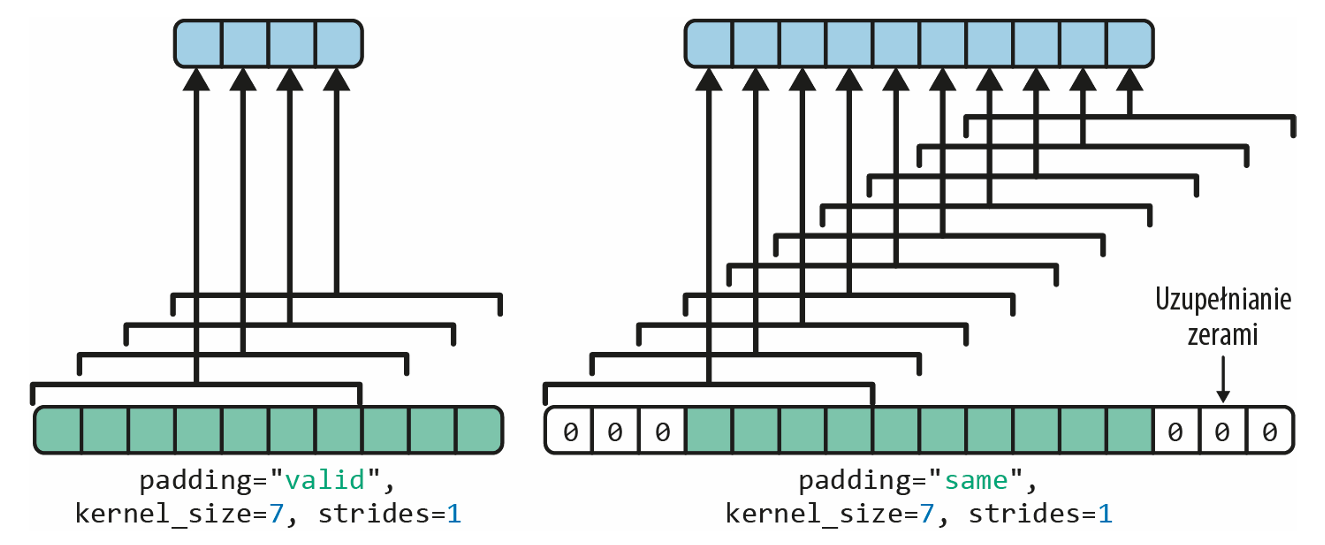

$$
z_{i,j,k} = b_k \sum_{u=0}^{f_h - 1} \sum_{v=0}^{f_w - 1} \sum_{k'=0}^{f_{n'} - 1} x_{i',j',k'} \cdot w_{u,v,k',k},
\quad \text{gdzie} \quad
\begin{cases}
i' = i \times s_h + u \\
j' = j \times s_w + v
\end{cases}
$$



In [ ]:
kernels, biases = conv_layer.get_weights()

In [ ]:
# BRAK WYSOKOSCI I SZEROKOSCI, ponieważ wszystkie neurony w wyjściowych mapach cech współdzielą te same wagi
# Zatem mogę dostarczać do tej warstwy obrazy o dowolnych rozmiarach
# (pod warunkiem, ze są tak duże jak jądra i posiadają odpowiednia liczbę kanałów !!!)

# [wysokosc jadra, szerokosc jadra, kanaly wejsciowe, kanaly wyjsciowe]
kernels.shape

(7, 7, 3, 32)

In [ ]:
# liczba kanały wyjściowe = liczba wyjścowych map cech = liczba filtrów

# [kanaly wyjsciowe]
biases.shape

(32,)

Watstwa łącząca (Pooling layers)

Celem warstwy POOLING LAYERS jest SUBSAMPLE - zmniejszenie obrazu wejściowego w celu zredukowania obciążenia obliczeniowego, wykorzystania pamięci i liczby parametrów.

Jej jedyne zadanie to gromadzenie danych wejściowych za pomocą jakieś funkcji agregacyjnej (np. maksymalizacyjna).

Klasyfikacja za pomocą gotowej sieci Xception

In [1]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)
dataset_size = info.splits["train"].num_examples
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [2]:
# podzial: początkowe 10% na testowanie, następne 15% na walidacje, pozostałe 75% na uczenie

test_set_raw, valid_set_raw, train_set_raw = tfds.load(
"tf_flowers",
split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
as_supervised=True)

In [3]:
dataset_size

3670

In [4]:
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [5]:
n_classes

5

In [6]:
#info

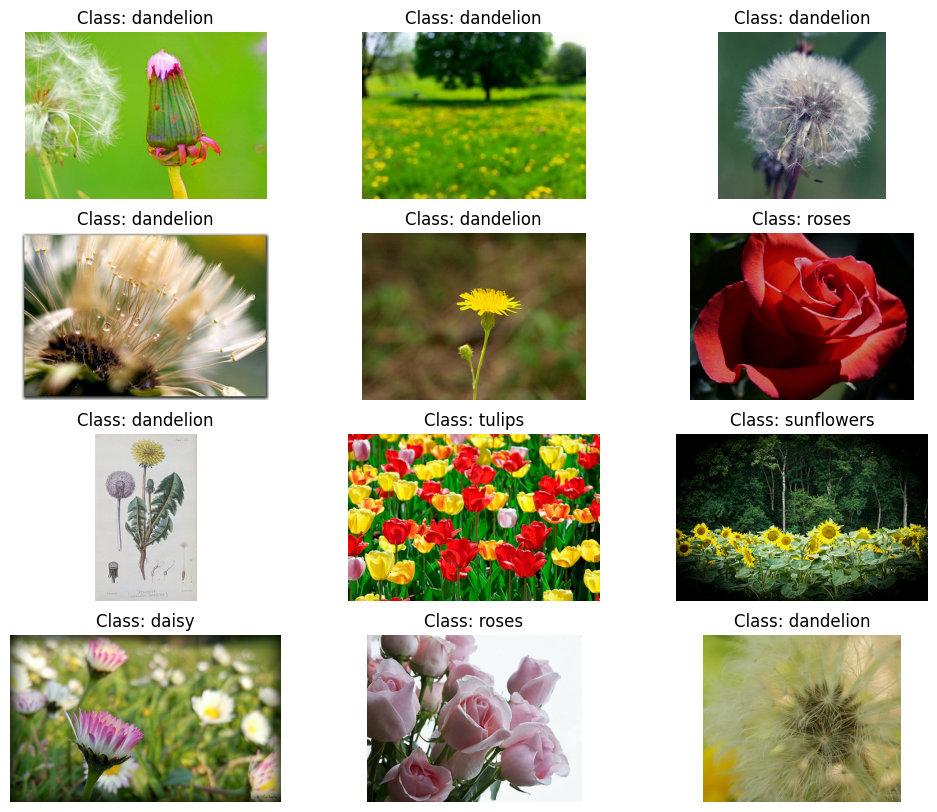

In [7]:
import matplotlib.pyplot as plt

# wyglad zbioru walidacyjnego

plt.figure(figsize=(12, 10))
index = 0
# iteruje przez 12 pierwszych obrazow i ich etykiety
for image, label in valid_set_raw.take(12):
    index += 1
    plt.subplot(4, 3, index)
    plt.imshow(image)
    plt.title(f"Class: {class_names[label]}")
    plt.axis("off")

plt.show()

In [8]:
import tensorflow as tf

# upewniam się, że poprzednie modele nie obciążają pamięci i nie wpływają na nowy model
tf.keras.backend.clear_session()

In [9]:
# najpierw muszę się upewnić, że obrazy maja takie same rozmiary, poniewaz bez tego tworzenie grup sie nie powiedzie
# w tym celu uzywam Resising

# liczba obrazow przetwarzanych w 1 paczce
batch_size = 32

preprocess = tf.keras.Sequential([
    # przeskalowanie obrazu do rozmiaru 224 x 224
    # crop_to_aspect_ratio=True – brak deformowania obrazu, zachowuje proporcje, przycinając go, jeśli to konieczne
    tf.keras.layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True),
    # wstepne przetowrzenie obrazu z mysla o medu Xception
    tf.keras.layers.Lambda(tf.keras.applications.xception.preprocess_input)
])
train_set = train_set_raw.map(lambda X, y: (preprocess(X), y))
# musze wymieszac dane w losowej kolejności, aby model nie uczył się przypadkowych wzorców w kolejności obrazów
# .batch(batch_size) -> grupuje dane w paczki wstępnie ładując 1 batch danych do pamięci
train_set = train_set.shuffle(1000, seed=42).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)
test_set = test_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)

In [10]:
# dogenerowanie danych

data_augmentation = tf.keras.Sequential([
    # odbijam obraz w poziomie z prawdopodobienstwem 50%
    tf.keras.layers.RandomFlip(mode="horizontal", seed=42),
    # losowo obracam obraz o maksymalnie 5% kata pelnego (0.05 * 360 = 18 stopni)
    tf.keras.layers.RandomRotation(factor=0.05, seed=42),
    # losowo zmieniam kontrast obrazu o +,- 20%
    #tf.keras.layers.RandomContrast(factor=0.2, seed=42),
    # powieksza lub zmniejsza obraz w zakresie +,- 20%
    #tf.keras.layers.RandomZoom(height_factor=0.2, width_factor=0.2, seed=42),
    # zmiana jasnosci o +, - 20%
    #tf.keras.layers.RandomBrightness(factor=0.2, seed=42)
])

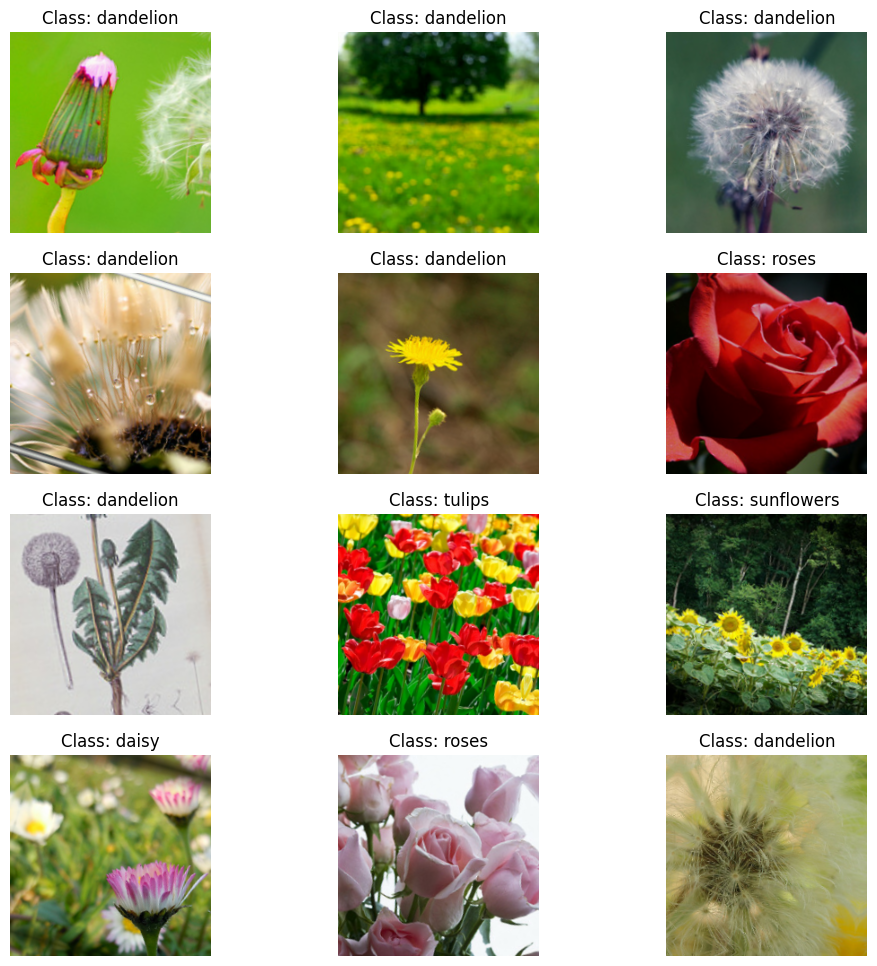

In [11]:
# widok po augumentacji
import numpy as np

plt.figure(figsize=(12, 12))
for X_batch, y_batch in valid_set.take(1):
    X_batch_augmented = data_augmentation(X_batch, training=True)
    for index in range(12):
        plt.subplot(4, 3, index + 1)

        # przeskalowanie do  0-1
        plt.imshow(np.clip((X_batch_augmented[index] + 1) / 2, 0, 1))
        plt.title(f"Class: {class_names[y_batch[index]]}")
        plt.axis("off")

plt.show()

In [12]:
# wczytuje model Xception, wytrenowany na zestawie danych ImageNet
# wykluczam górną część sieci poprzez wyznaczenie parametru include_top=False, poniewaz
# dzieki temu pomijam globalną uśredniającą warstwę łączącą i gęstą warstwę wyjściową
# weights="imagenet" -> laduje wagi z wcześniej wytrenowanego modelu

base_model = tf.keras.applications.xception.Xception(weights="imagenet", include_top=False)

# konwertuje wyjście z konwolucji na jednowymiarowy wektor przez uśrednianie wartości
# jest to alternatywa dla Flatten(), ale redukuje liczbe parametrow, co poprawi generalizacje

# jest to warstwa globalnego usredniania
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)

# dodanie w pelni polaczonej warstwy gestej o 'n_classes' neuronach, gdzie kazdy neuron odpowiada jednej klasie
# softmax konwertuje wyjscie na prawdopodobienstwo przynaleznosci do klasy
output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)

# utworzenie nowego modelu keras
model = tf.keras.Model(inputs=base_model.input, outputs=output)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [13]:
# dobra praktyka jest zamrazanie wag wytrenowanych warstw (w szczegolnosci na poczatku procesu uczenia).
# stosuje sie to w szczegolnosci w przypadku transfer learningu poniewaz model juz nauczyl sie ogolnych
# cech i nie ma potrzeby trenowania ich od nowa

for layer in base_model.layers:
    layer.trainable = False

In [14]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=3)

Epoch 1/3
86/86 ━━━━━━━━━━━━━━━━━━━━ 37s 251ms/step - accuracy: 0.6980 - loss: 1.0651 - val_accuracy: 0.8330 - val_loss: 0.6796
Epoch 2/3
86/86 ━━━━━━━━━━━━━━━━━━━━ 13s 142ms/step - accuracy: 0.9212 - loss: 0.2913 - val_accuracy: 0.8639 - val_loss: 0.5675
Epoch 3/3
86/86 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - accuracy: 0.9288 - loss: 0.2129 - val_accuracy: 0.8730 - val_loss: 0.5454
